<a href="https://colab.research.google.com/github/seenu-g/school_of_ai/blob/master/chap6/assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


**Model**

In [0]:
dropout_value = 0.03
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layer1 = nn.Sequential(                      
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=True),#Op_size = 26, RF = 3
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            nn.Dropout2d(dropout_value)
        )
        self.conv_layer2 = nn.Sequential(  
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=True),#Op_size = 24, RF = 5
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            nn.Dropout2d(dropout_value)
        )
        self.maxpool_layer1 = nn.MaxPool2d(kernel_size=(2,2)) #Op_size = 12, RF = 6
        self.conv_layer3 = nn.Sequential(  
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=True), #Op_size = 10, RF = 10   
            nn.ReLU(),
            nn.BatchNorm2d(num_features=14),
            nn.Dropout2d(dropout_value)
        )
        self.conv_layer4 = nn.Sequential(  
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=True), #Op_size = 8, RF = 14
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout2d(dropout_value) 
        )
        self.conv_layer5 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=True),#Op_size = 6, RF = 18 
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout(dropout_value)
        )
        self.conv_layer6 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=True),#Op_size = 6, RF = 22 
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout(dropout_value)
        )            
        self.avgpool_layer1 = nn.AvgPool2d(kernel_size=6)

        self.conv_layer7 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=True)#Op_size = 1, RF = 28
        )

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x =  self.maxpool_layer1(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = self.conv_layer6(x)
        x = self.avgpool_layer1(x)
        x = self.conv_layer7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

*italicized text*# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1,28,28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
         Dropout2d-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,308
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
         Dropout2d-8           [-1, 12, 24, 24]               0
         MaxPool2d-9           [-1, 12, 12, 12]               0
           Conv2d-10           [-1, 14, 10, 10]           1,526
             ReLU-11           [-1, 14, 10, 10]               0
      BatchNorm2d-12           [-1, 14, 10, 10]              28
        Dropout2d-13           [-1, 14, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
def L1_Loss(model, data, factor=0.0005):
  l1_crit = nn.L1Loss().to(device)
  reg_loss = 0
  
  for param in model.parameters():
    zero_vector = torch.rand_like(param) * 0
    reg_loss += l1_crit(param, zero_vector)

  
  return factor * reg_loss

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch,isL1=False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    #CAlculate L1 loss
    if(isL1==True):
      loss += L1_Loss(model,data,factor=0.0005)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Epoch={epoch} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader,test_losses, test_acc, misclassified):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            for i in range(len(pred)):
              if pred[i]!= target[i]:
                misclassified.append([data[i], pred[i], target[i]])
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_test_loss_acc(test_losses,test_acc):
  fig, axs = plt.subplots(1,2,figsize=(15,10))
  axs[0].plot(test_losses)
  axs[0].set_title("Test Loss")
  axs[1].plot(test_acc)
  axs[1].set_title("Test Accuracy")

In [0]:
def plot_misclassified(misclassified):
  fig = plt.figure(figsize = (10,10))
  for i in range(25):
        sub = fig.add_subplot(5, 5, i+1)
        plt.imshow(misclassified[i][0].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
        
        sub.set_title("Pred={}, Act={}".format(str(misclassified[i][1].data.cpu().numpy()),str(misclassified[i][2].data.cpu().numpy())))
        
  plt.tight_layout()

  plt.show()

In [0]:
def without_L1L2():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  EPOCHS = 40
  for epoch in range(EPOCHS):
     print("EPOCH:", epoch)
     train(model, device, train_loader, optimizer, epoch, False)
     test(model, device, test_loader,test_without_L1L2_Loss, test_without_L1L2_acc,misclassifiedwithoutL1L2)
  
  plot_test_loss_acc(test_without_L1L2_Loss,test_without_L1L2_acc)
  plot_misclassified(misclassifiedwithoutL1L2)

In [0]:
def with_L1():
    
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  #scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, True)
      test(model, device, test_loader,test_with_L1_Loss, test_with_L1_acc,misclassifiedL1)

  plot_test_loss_acc(test_with_L1_Loss, test_with_L1_acc)
  plot_misclassified(misclassifiedL1)

In [0]:
def with_L2():
    
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

  #scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, False)
      test(model, device, test_loader,test_with_L2_Loss, test_with_L2_acc,misclassifiedL2)

  plot_test_loss_acc(test_with_L2_Loss,test_with_L2_acc)
  plot_misclassified(misclassifiedL2)

In [0]:
def with_L1_L2():
    
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

  #scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, True)
      test(model, device, test_loader,test_with_L1L2_Loss, test_with_L1L2_acc,misclassifiedL1L2)

  plot_test_loss_acc(test_with_L1L2_Loss,test_with_L1L2_acc)
  plot_misclassified(misclassifiedL1L2)

In [0]:
test_without_L1L2_Loss = []
test_without_L1L2_acc = []
misclassifiedwithoutL1L2= []

test_with_L1_Loss = []
test_with_L1_acc = []
misclassifiedL1 = []

test_with_L2_Loss = []
test_with_L2_acc = []
misclassifiedL2 = []

test_with_L1L2_Loss = []
test_with_L1L2_acc = []
misclassifiedL1L2 = []

from torch.optim.lr_scheduler import StepLR

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Epoch=0 Loss=0.046933189034461975 Batch_id=468 Accuracy=88.54: 100%|██████████| 469/469 [00:12<00:00, 36.32it/s]



Test set: Average loss: 0.0722, Accuracy: 9829/10000 (98.29%)



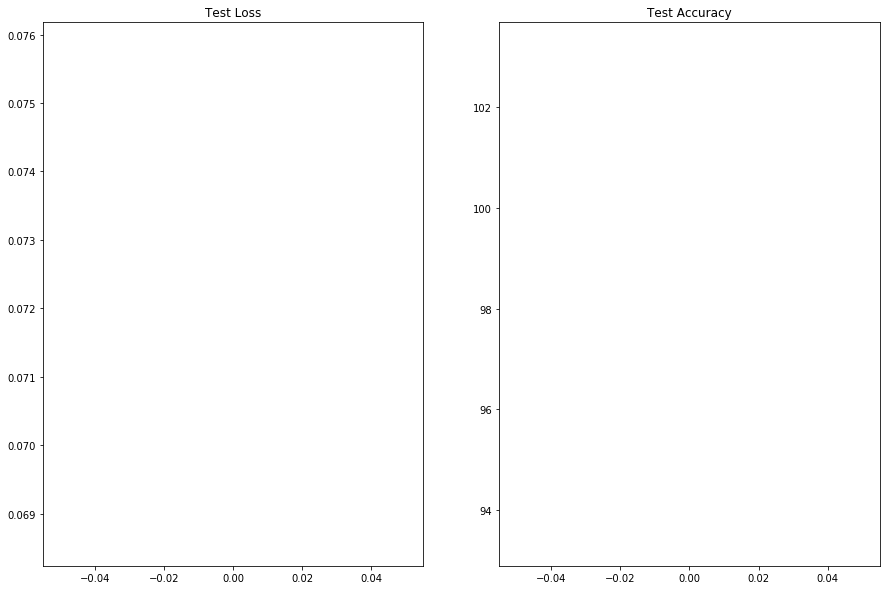

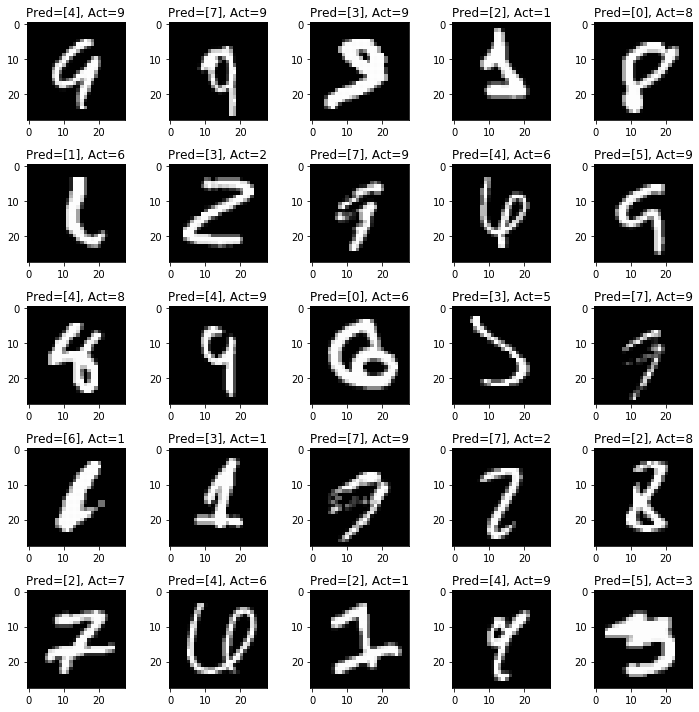

In [0]:
without_L1L2()


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Epoch=0 Loss=0.09634151309728622 Batch_id=468 Accuracy=88.41: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]



Test set: Average loss: 0.0705, Accuracy: 9806/10000 (98.06%)



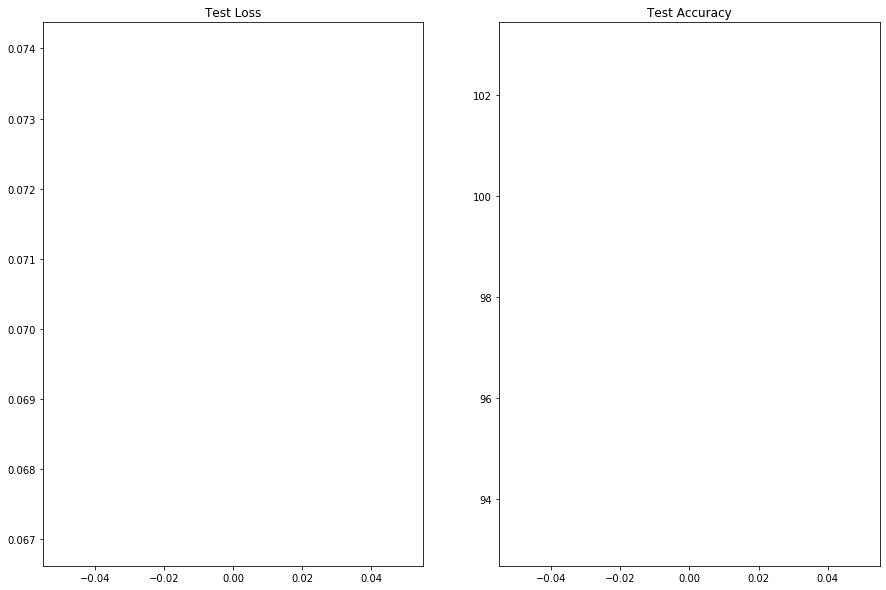

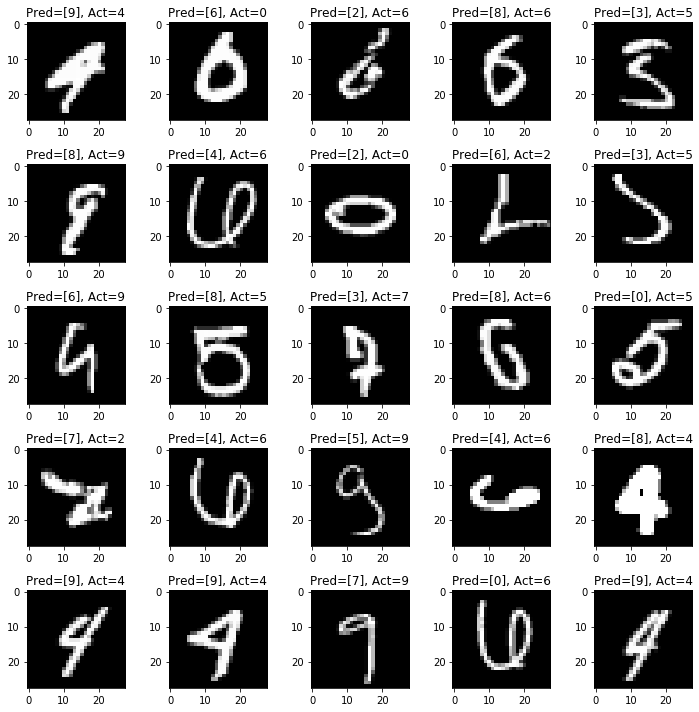

In [0]:
with_L1()

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Epoch=0 Loss=0.12013745307922363 Batch_id=468 Accuracy=89.52: 100%|██████████| 469/469 [00:13<00:00, 35.32it/s]



Test set: Average loss: 0.0856, Accuracy: 9826/10000 (98.26%)



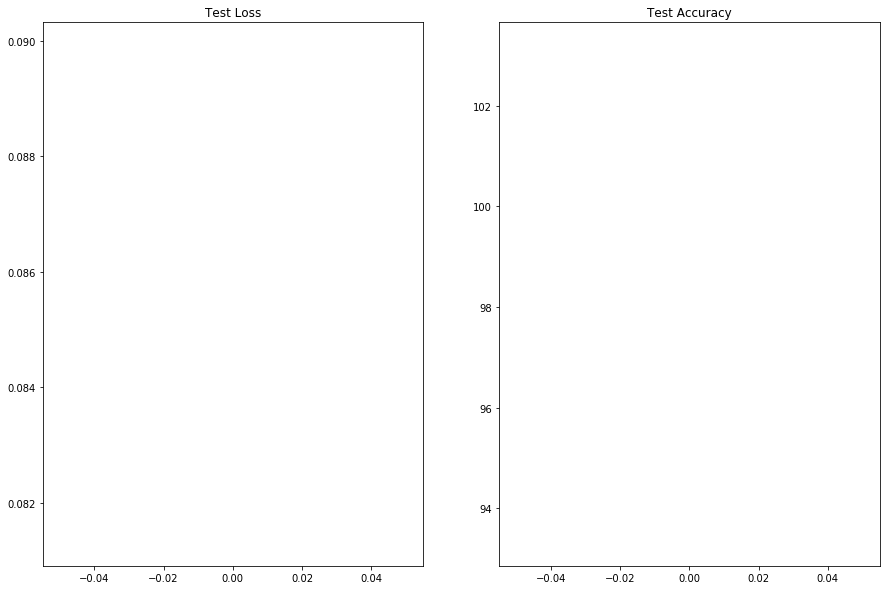

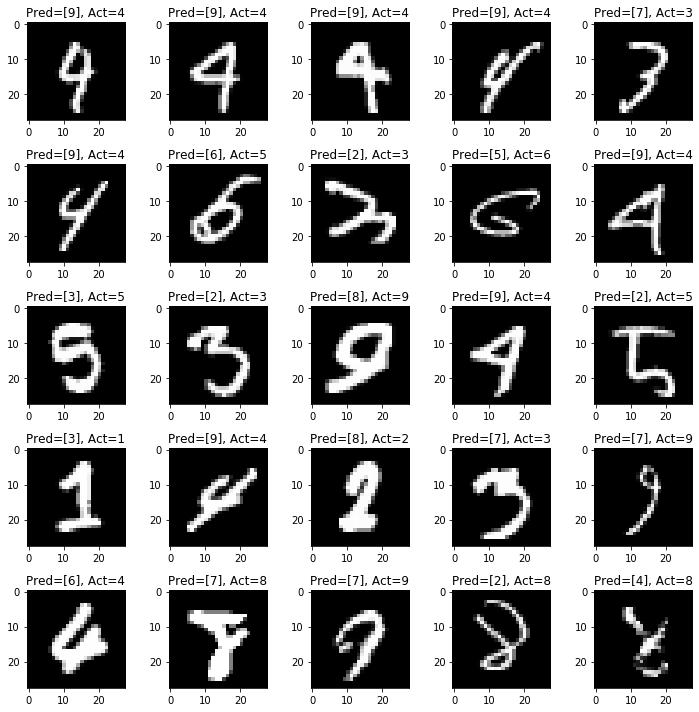

In [0]:
with_L2()

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Epoch=0 Loss=0.0791974812746048 Batch_id=468 Accuracy=88.01: 100%|██████████| 469/469 [00:15<00:00, 29.36it/s]



Test set: Average loss: 0.0936, Accuracy: 9776/10000 (97.76%)



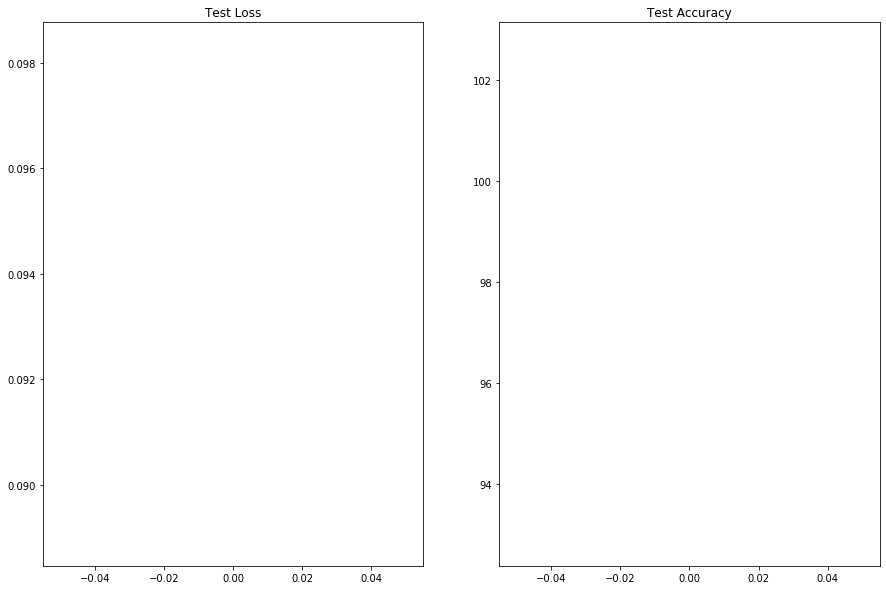

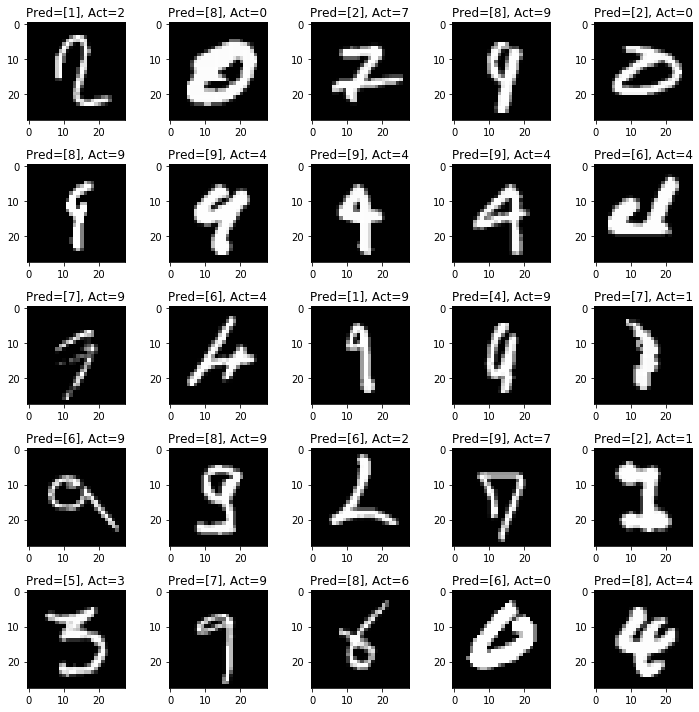

In [0]:
with_L1_L2()

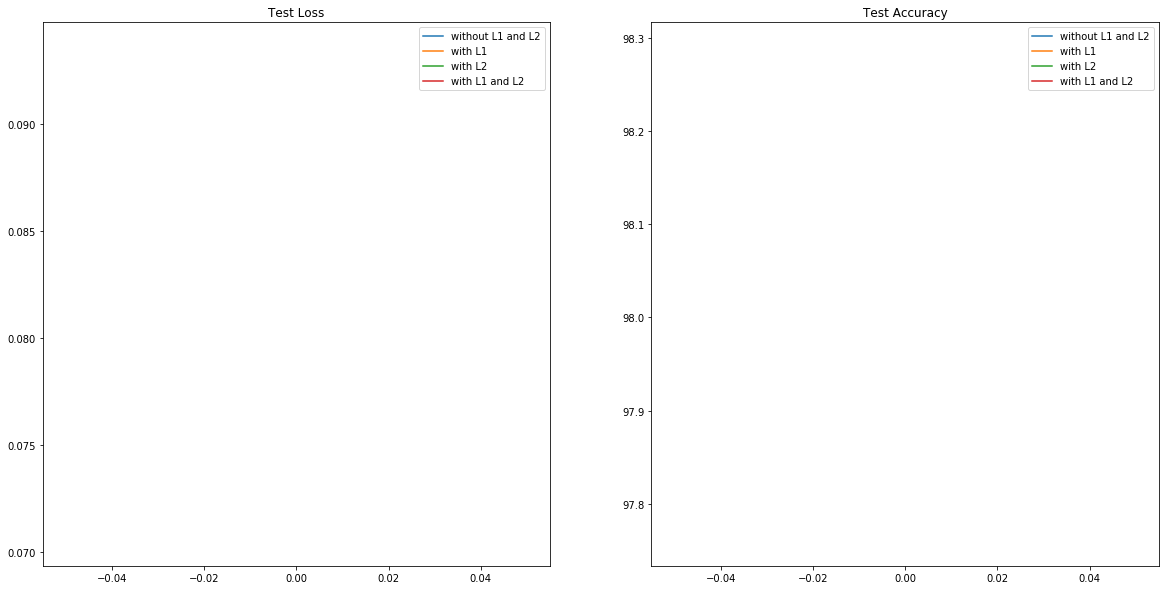

In [0]:
fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].plot(test_without_L1L2_Loss, label='without L1 and L2')
axs[0].plot(test_with_L1_Loss, label='with L1 ')
axs[0].plot(test_with_L2_Loss, label='with L2 ')
axs[0].plot(test_with_L1L2_Loss, label='with L1 and L2 ')
axs[0].set_title("Test Loss")
axs[0].legend()
axs[1].plot(test_without_L1L2_acc, label='without L1 and L2')
axs[1].plot(test_with_L1_acc, label='with L1 ')
axs[1].plot(test_with_L2_acc, label='with L2')
axs[1].plot(test_with_L1L2_acc, label='with L1 and L2 ')
axs[1].set_title("Test Accuracy")
axs[1].legend()